## Imports

In [3]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

/Users/ibendaya/anaconda3/envs/basic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset visualization

In [4]:
# Load the CoNLL2003 dataset
dataset = load_dataset("conll2003")

# Print a sample from the dataset
print("Sample from training data:")
print(dataset['train'][0])

Generating test split: 100%|██████████| 3453/3453 [00:00<00:00, 21578.41 examples/s]

Sample from training data:
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


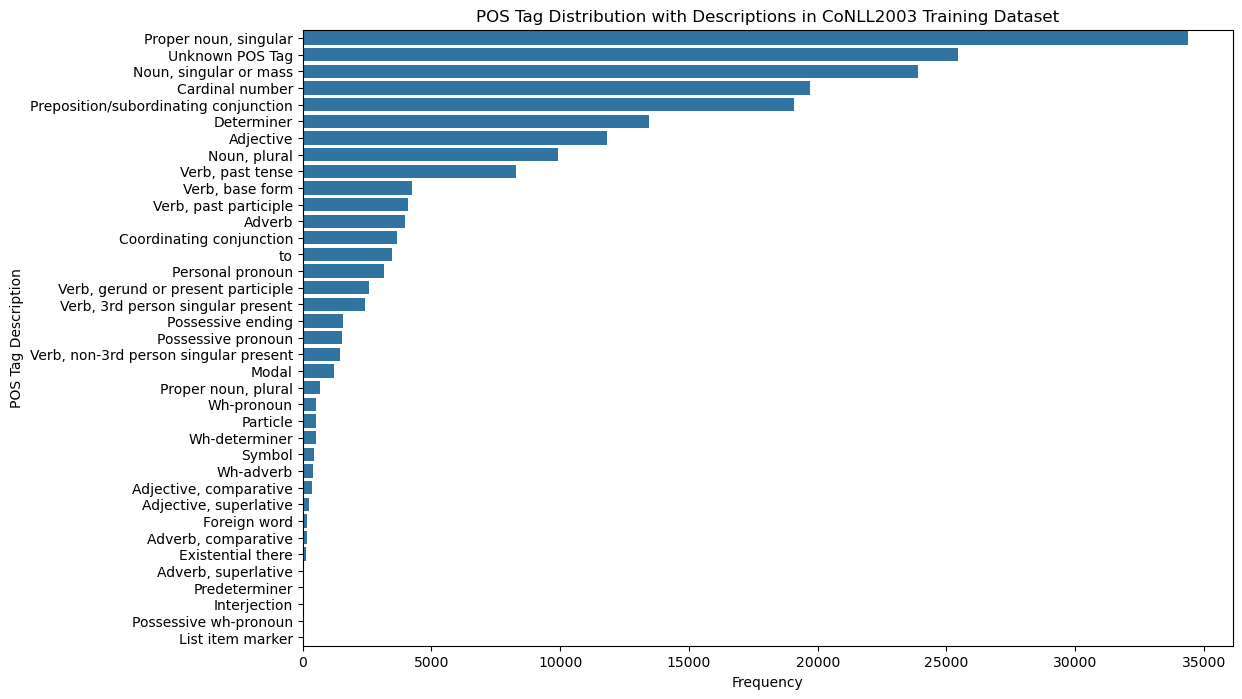

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Penn Treebank POS Tag descriptions
pos_tag_descriptions = {
    "CC": "Coordinating conjunction",
    "CD": "Cardinal number",
    "DT": "Determiner",
    "EX": "Existential there",
    "FW": "Foreign word",
    "IN": "Preposition/subordinating conjunction",
    "JJ": "Adjective",
    "JJR": "Adjective, comparative",
    "JJS": "Adjective, superlative",
    "LS": "List item marker",
    "MD": "Modal",
    "NN": "Noun, singular or mass",
    "NNS": "Noun, plural",
    "NNP": "Proper noun, singular",
    "NNPS": "Proper noun, plural",
    "PDT": "Predeterminer",
    "POS": "Possessive ending",
    "PRP": "Personal pronoun",
    "PRP$": "Possessive pronoun",
    "RB": "Adverb",
    "RBR": "Adverb, comparative",
    "RBS": "Adverb, superlative",
    "RP": "Particle",
    "SYM": "Symbol",
    "TO": "to",
    "UH": "Interjection",
    "VB": "Verb, base form",
    "VBD": "Verb, past tense",
    "VBG": "Verb, gerund or present participle",
    "VBN": "Verb, past participle",
    "VBP": "Verb, non-3rd person singular present",
    "VBZ": "Verb, 3rd person singular present",
    "WDT": "Wh-determiner",
    "WP": "Wh-pronoun",
    "WP$": "Possessive wh-pronoun",
    "WRB": "Wh-adverb"
}

# Handle missing tags by providing a default description
def get_pos_description(tag):
    return pos_tag_descriptions.get(tag, "Unknown POS Tag")

# Convert tag indices to descriptions
train_pos_tags_named = [get_pos_description(pos_tag_vocab[tag]) for tag in train_pos_tags]

# Count POS tag descriptions
pos_tag_counts = Counter(train_pos_tags_named)

# Sort tags by frequency
sorted_pos_counts = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Plot POS tag distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=list(sorted_pos_counts.values()), y=list(sorted_pos_counts.keys()), orient='h')
plt.title("POS Tag Distribution with Descriptions in CoNLL2003 Training Dataset")
plt.xlabel("Frequency")
plt.ylabel("POS Tag Description")
plt.show()

In [15]:
import pandas as pd

# Function to visualize a sample sentence with tokens and their POS descriptions
def visualize_sample_with_pos(dataset, sample_idx=0):
    # Fetch the sample
    sample = dataset['train'][sample_idx]
    
    # Get tokens
    tokens = sample['tokens']
    
    # Convert POS tag indices to their descriptions
    pos_tags = [get_pos_description(pos_tag_vocab[tag]) for tag in sample['pos_tags']]
    
    # Create a DataFrame for easy visualization
    df = pd.DataFrame({
        'Token': tokens,
        'POS Description': pos_tags
    })
    
    print(f"Sample {sample_idx} Visualization:")
    print(df)
    return df

# Visualize a sample sentence with POS descriptions
df = visualize_sample_with_pos(dataset, sample_idx=5)


Sample 5 Visualization:
             Token                        POS Description
0                "                        Unknown POS Tag
1               We                       Personal pronoun
2               do  Verb, non-3rd person singular present
3              n't                                 Adverb
4          support                        Verb, base form
5              any                             Determiner
6             such                              Adjective
7   recommendation                 Noun, singular or mass
8          because  Preposition/subordinating conjunction
9               we                       Personal pronoun
10              do  Verb, non-3rd person singular present
11             n't                                 Adverb
12             see                        Verb, base form
13             any                             Determiner
14         grounds                           Noun, plural
15             for  Preposition/subordinating co

## Train

In [ ]:
# Install required libraries
# !pip install transformers datasets seqeval

import datasets
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification
import numpy as np

# Load dataset and metric
dataset = load_dataset("conll2003")
metric = load("seqeval")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Get label list and number of labels
label_list = dataset["train"].features["pos_tags"].feature.names
num_labels = len(label_list)

# Tokenize and align labels
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special token
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # First token of the word
            else:
                if label_all_tokens:
                    label_ids.append(label[word_idx])  # Same word, copy label
                else:
                    label_ids.append(-100)  # Masked
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels,
    id2label={str(i): label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)}
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "accuracy": results["overall_accuracy"],
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate(tokenized_datasets["test"])
print(eval_results)
